## 1. Train DBP+ADF

In [1]:
"""
Train MetaDSP Model with split windows.
"""

import pickle, torch, numpy as np, time
t0 = time.time()
import argparse, os , yaml
from torch.utils.data import DataLoader
from functools import partial
from torch.utils.tensorboard.writer import SummaryWriter
from src.TorchDSP.core import TorchInput, TorchSignal, TorchTime
from src.TorchDSP.dsp import DSP, LDBP, downsamp, ADF
from src.TorchDSP.dataloader import  MyDataset
from src.TorchDSP.loss import BER_well, MSE, SNR, Qsq
from src.TorchSimulation.receiver import  BER
t1 = time.time()
print(f"Import Time: {t1-t0:.2f}s")
with open('configs/metadsp/fdbp.yaml', 'r') as f:
    config = yaml.safe_load(f)


def avg_phase(x,y):
    return torch.angle(torch.mean(x*torch.conj(y), dim=1, keepdim=True))

def rotation_free_MSE(x,y):
    # x, y: [batch, L, Nmodes]
    theta = avg_phase(x,y)
    return torch.mean(torch.abs(torch.exp(-1j*theta)*x - y)**2)


# Test DBP + static filter
def test_model(net, conv, test_loader, device):
    net.eval()
    conv.eval()
    with torch.no_grad():
        N = len(test_loader)
        test_loss = 0
        ber = 0
        for Rx, Tx, info in test_loader:
            signal_input = TorchSignal(val=Rx, t=TorchTime(0,0,2)).to(device)
            signal_output = TorchSignal(val=Tx, t=TorchTime(0,0,1)).to(device)
            info = info.to(device)
            y = net(signal_input, info)
            y = conv(y)
            truth = signal_output.val[:, y.t.start:y.t.stop]
            loss = MSE(y.val, truth)

            test_loss += loss.item()
            ber += np.mean(BER(y.val, truth)['BER'])
    return {'MSE': test_loss/N, 'BER': ber/N, 'Qsq': Qsq(ber/N)} 

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
import jax
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime

@partial(jax.jit, backend='cpu', static_argnums=(2))   
def DDLMS_jax(Rx, Tx, taps=32):
    signal = MySignal(val=Rx, t=SigTime(0,0,2), Fs=0)
    truth = MySignal(val=Tx, t=SigTime(0,0,1), Fs=0)
    model = mimoaf(taps=taps, train=lambda n: n<2000, mimofn=af.ddlms, learnable=False)
    z, state = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
    return z

# Test DBP + ADF
def Test(net, device='cuda:0', taps=32, power=2):

    # load data
    test_data = MyDataset(config['test_path'], Nch=[21], Rs=[80], Pch=[power],Nmodes=2,
                        window_size=net.overlaps + (taps//2 - 1) + 200000, strides=100000, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx')
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=True)

    for Rx, Tx, info in test_loader:
        break
    signal = TorchSignal(val=Rx, t=TorchTime(0,0,2)).to(device)
    symb = TorchSignal(val=Tx, t=TorchTime(0,0,1)).to(device)
    info = info.to(device)

    # DBP
    with torch.no_grad():
        y = net(signal, info)
    
    # ADF
    sig_in = jax.numpy.array(y.val[0].cpu().numpy())
    symb_in = jax.numpy.array(symb.val[0, y.t.start//y.t.sps:y.t.stop//y.t.sps].cpu().numpy())
    z = DDLMS_jax(sig_in, symb_in, taps=taps)

    # metric
    z1 = torch.tensor(jax.device_get(z.val[20000:]))
    z2 = torch.tensor(jax.device_get(symb_in[z.t.start:z.t.stop][20000:]))
    mse = MSE(z1, z2)
    ber = np.mean(BER(z1, z2)['BER'])

    return {'MSE': mse, 'BER': ber, 'Qsq': Qsq(ber)} 

Import Time: 1.56s


In [18]:
config['epochs'] = 15
config['device'] = 'cpu'
save = False
shuffle = False
Qp = {}
for train_pch in [[-2], [2], [6]]:

    for tbpl in [200]:
        for batch_size in [20]:

            print(f'*********** Training with tbpl={tbpl}, batch_size={batch_size} *********')

            config['device'] = 'cuda:0'
            config['tbpl'] = tbpl
            config['batch_size'] = batch_size
            

            net = LDBP(config['model_info']['DBP_info'])
            conv = ADF(method='ddlms', taps=32, Nmodes=2, batch_size=config['batch_size'])
            net.to(config['device'])
            conv.to(config['device'])
            optimizer = torch.optim.Adam([{'params': net.parameters(), 'lr': 3e-4}, {'params': conv.parameters(), 'lr': 3e-4}])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

            window_size = config['tbpl'] + net.overlaps + conv.overlaps
            device = config['device']
            batch_size = config['batch_size']
            epochs = config['epochs']
            tbpl = config['tbpl']                       # truncated backpropagation length
            lr = config['lr']

            train_data = MyDataset(config['train_path'], Nch=[21], Rs=[80], Pch=train_pch, Nmodes=2,
                                window_size=window_size, strides=config['tbpl'], Nwindow=10000, truncate=0,
                                Tx_window=True, pre_transform='Rx')
            torch.manual_seed(12)   
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)


            writer = SummaryWriter(f'_outputs/log_tensorboard/metadsp/train_dsp_tbpl{tbpl}_batch{batch_size}_trainpch{train_pch[0]}')

            print('Train Loader batchs:', len(train_loader))

            for epoch in range(epochs): 
                N = len(train_loader)
                train_loss = 0
                t0 = time.time()
                for Rx, Tx, info in train_loader:
                    
                    signal_input = TorchSignal(val=Rx, t=TorchTime(0,0,2)).to(device)
                    signal_output = TorchSignal(val=Tx, t=TorchTime(0,0,1)).to(device)
                    info = info.to(device)
                    y = net(signal_input, info)  # [B, L, N]
                    y = conv(y, signal_output, info)
                    truth = signal_output.val[:, y.t.start:y.t.stop]     # [B, L, N]
                    loss = MSE(y.val, truth)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    conv.detach_state()
                    train_loss += loss.item()
                    print(loss.item(), end='\r', flush=True)

                t1 = time.time()
                scheduler.step()
                res = Test(net, device, taps=32)
                writer.add_scalar('Loss/train', train_loss/N, epoch)
                writer.add_scalar('Loss/test', res['MSE'], epoch)
                writer.add_scalar('Metric/Qsq', res['Qsq'], epoch)
                writer.add_scalar('Metric/BER', res['BER'], epoch)
                print('Epoch: %d, Loss: %.5f, time: %.5f' % (epoch, train_loss/N, t1-t0), flush=True)
                print('Test BER: %.5f, Qsq: %.5f, MSE: %.5f' % (res['BER'], res['Qsq'], res['MSE']), flush=True)

                if epoch % 1 == 0 and save:
                    torch.save(net.state_dict(), f'_models/metadsp/train_dsp/net_{epoch}.pth')
                    torch.save(conv.state_dict(), f'_models/metadsp/train_dsp/conv_{epoch}.pth')
                    print('Model saved')
    
    Qp[str(train_pch[0])] = [Test(net, device, taps=32, power=p)['Qsq'] for p in range(-3, 8)]

# # save Qp 
# import pickle
# with open('Qp.pkl', 'wb') as f:
#     pickle.dump(Qp, f)

*********** Training with tbpl=200, batch_size=20 *********
Train Loader batchs: 121
Epoch: 0, Loss: 0.10914, time: 79.93952
Test BER: 0.01227, Qsq: 7.03760, MSE: 0.04395
Epoch: 1, Loss: 0.04975, time: 79.39580
Test BER: 0.01048, Qsq: 7.26682, MSE: 0.04143
Epoch: 2, Loss: 0.04939, time: 79.04477
Test BER: 0.00922, Qsq: 7.44665, MSE: 0.03974
Epoch: 3, Loss: 0.04915, time: 79.61734
Test BER: 0.00843, Qsq: 7.56640, MSE: 0.03858
Epoch: 4, Loss: 0.04897, time: 79.77903
Test BER: 0.00785, Qsq: 7.66047, MSE: 0.03765
Epoch: 5, Loss: 0.04868, time: 79.54124
Test BER: 0.00754, Qsq: 7.71345, MSE: 0.03721
Epoch: 6, Loss: 0.04859, time: 79.04934
Test BER: 0.00724, Qsq: 7.76685, MSE: 0.03675
Epoch: 7, Loss: 0.04852, time: 79.36811
Test BER: 0.00699, Qsq: 7.81080, MSE: 0.03631
Epoch: 8, Loss: 0.04845, time: 79.46453
Test BER: 0.00676, Qsq: 7.85241, MSE: 0.03595
Epoch: 9, Loss: 0.04839, time: 79.47463
Test BER: 0.00656, Qsq: 7.89135, MSE: 0.03561
Epoch: 10, Loss: 0.04834, time: 79.07862
Test BER: 0.00

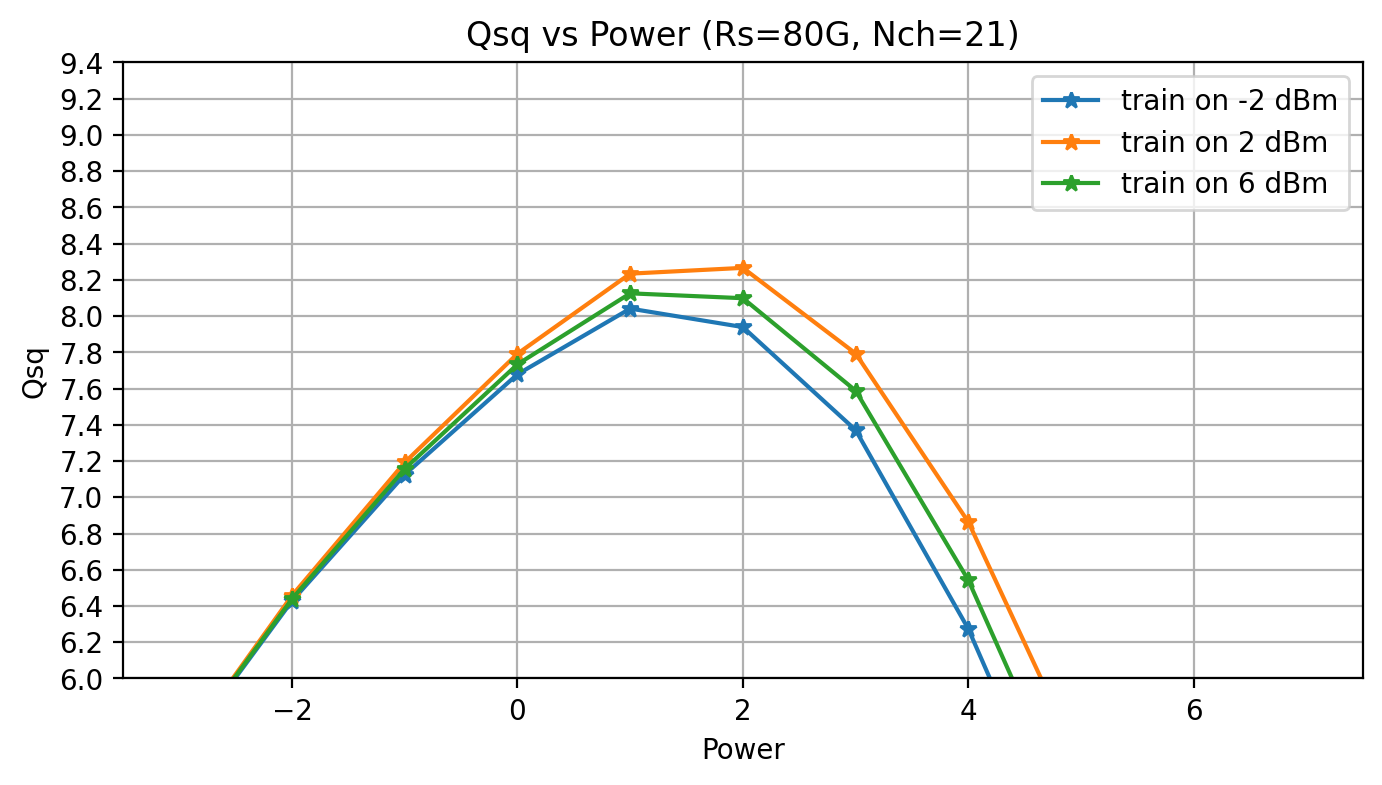

In [22]:
import matplotlib.pyplot as plt

plt.figure(dpi=200, figsize=(8,4))
for key in Qp.keys():
    plt.plot(range(-3,8), Qp[key], '-*', label=f'train on {key} dBm')


plt.legend()
plt.ylim(6, 9)
plt.yticks(np.arange(6, 9.5, 0.2))
plt.xlabel('Power')
plt.ylabel('Qsq')
plt.title('Qsq vs Power (Rs=80G, Nch=21)')
plt.grid()

In [6]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def get_Q(tbpl, batch):
    logdir = f'_outputs/log_tensorboard/metadsp/train_dsp_tbpl{tbpl}_batch{batch}'  # TensorBoard 日志文件路径
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    return event_acc.Scalars('Metric/Qsq')[-1].value

def get_time(tbpl, batch):
    # get time (min)
    logdir = f'_outputs/log_tensorboard/metadsp/train_dsp_tbpl{tbpl}_batch{batch}'  # TensorBoard 日志文件路径
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    return (event_acc.Scalars('Metric/Qsq')[-1].wall_time - event_acc.Scalars('Metric/Qsq')[0].wall_time)/60

Q = [[get_Q(tbpl, k) for k in [50, 100, 200]] for tbpl in [200, 400, 800]]
T = [[get_time(tbpl, k) for k in [50, 100, 200]] for tbpl in [200, 400, 800]]

In [12]:
T[1]

[5.376033476988474, 3.3416630466779074, 2.324251985549927]

Text(0.5, 1.0, 'Q factor')

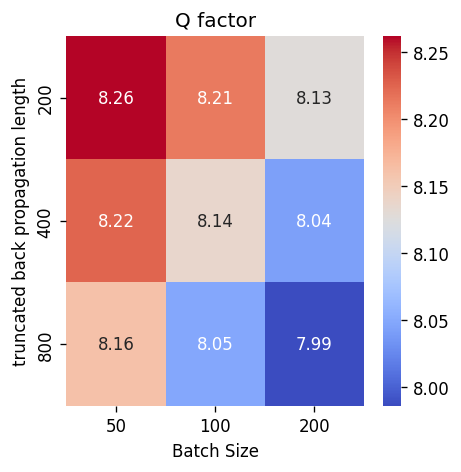

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

# show Q0 in a hitmap with .3f scheme, set range of color bar to -0.1 to 0.1
plt.figure(dpi=120, figsize=(4,4))
sns.heatmap(np.array(Q), annot=True, fmt='.2f', cmap='coolwarm', xticklabels=[50, 100, 200], yticklabels=[200, 400, 800])

plt.xlabel('Batch Size')
plt.ylabel('truncated back propagation length')
plt.title('Q factor')


## 2. Test Q-P

In [ ]:
import h5py, numpy as np, torch
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.receiver import  BER

def baselines(Nch, Rs, P = np.arange(-3, 8)):

    def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
        for key in f.keys():
            if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
                return f[key][f'Rx(sps=2,chid=0{tag})']
            
    def Q_power(f, Nch, pch, Rs,  method='Rx_CDCDDLMS(taps=32,lr=[0.015625, 0.0078125])'):
        grp = get_grp(f, Nch, Rs, pch, 500000, 4.5, 1.2, 2000)
        Q = Qsq(np.mean(BER(torch.from_numpy(grp[method][0])[100000:], torch.from_numpy(grp['Tx'][0,7:-8])[100000:])['BER']))
        return Q

    
    Q = {}

    with h5py.File('dataset_A800/train.h5', 'r') as f:
        Q['CDC'] = [Q_power(f, Nch, pch, Rs, 'Rx_CDCDDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
        Q['DBP1'] = [Q_power(f, Nch, pch, Rs, 'Rx_DBP1DDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
        Q['DBP2'] = [Q_power(f, Nch, pch, Rs, 'Rx_DBP2DDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
        Q['DBP4'] = [Q_power(f, Nch, pch, Rs, 'Rx_DBP4DDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
        Q['DBP8'] = [Q_power(f, Nch, pch, Rs, 'Rx_DBP8DDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
        Q['DBP16'] = [Q_power(f, Nch, pch, Rs, 'Rx_DBP16DDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
        Q['DBP32'] = [Q_power(f, Nch, pch, Rs, 'Rx_DBP32DDLMS(taps=32,lr=[0.015625, 0.0078125])') for pch in P]
    
    return Q

Q = baselines(21, 80)

In [7]:
Q

{'CDC': [5.550484235868144,
  6.386446292424585,
  7.076856304255928,
  7.565601973858227,
  7.886978784404043,
  7.69500484108579,
  7.052862663442035,
  5.881507060828806,
  4.386341678904894,
  -0.8598872393108763,
  -2.4119685795895967],
 'DBP1': [5.454278411093975,
  6.205727976056626,
  6.739526099230842,
  6.99549767312734,
  6.926895327970822,
  6.337066231774782,
  5.243508057867134,
  3.7761539912841346,
  -1.1953835996518116,
  -2.4451196942138718,
  -3.603090734084558],
 'DBP2': [5.493072972862279,
  6.282926976872892,
  6.882388260794454,
  7.230846395746967,
  7.296188235826496,
  6.873789312487926,
  5.923456677818303,
  4.574829422611691,
  -3.9764677533116894,
  -10.130048301868026,
  -3.075122087375944],
 'DBP4': [5.5524082117064335,
  6.395801306720614,
  7.086879471440027,
  7.606050539827467,
  7.909980373749653,
  7.7654375886024845,
  7.1186157769434715,
  6.034350084959677,
  4.4948077108327595,
  -0.7976468400887261,
  -2.415247528555802],
 'DBP8': [5.596074043

In [26]:
Qp = [Test(net, device, taps=32, power=p)['Qsq'] for p in range(-3, 8)]

In [55]:
dbp = LDBP(config['model_info']['DBP_info'])
dbp.load_state_dict(torch.load('_models/metadsp/train_dbp/net_40.pth'))
dbp.to(device)
Qp_conv = [Test(dbp, device, taps=32, power=p)['Qsq'] for p in range(-3, 8)]

In [65]:
dic = torch.load('_models/metadsp/fdbp/61.pth')
dic['model info']['DBP_info']['share'] = True
model = DSP(**dic['model info'])
model.load_state_dict(dic['model'])
model = model.to(device)

Qp_adf = [Test(model.ldbp, device, taps=32, power=p)['Qsq'] for p in range(-3, 8)]

In [66]:
Qp_adf

[5.590388702756222,
 6.4484880695637115,
 7.17828568233924,
 7.766358076035607,
 8.1845428246891,
 8.199669045093167,
 7.700503159543128,
 6.723326031918796,
 5.375554554382827,
 3.7087553519543803,
 1.6299972668353526]

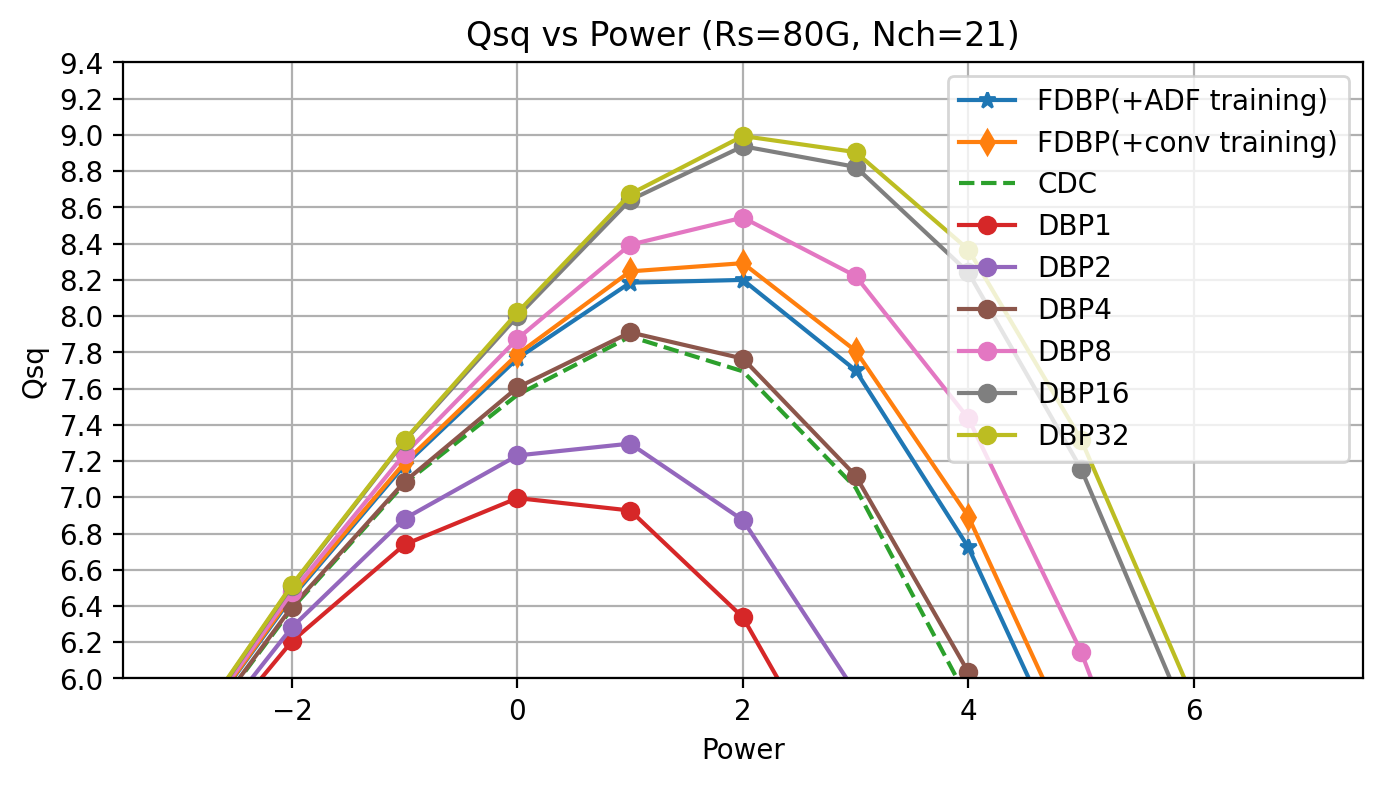

In [67]:
import matplotlib.pyplot as plt

plt.figure(dpi=200, figsize=(8,4))
plt.plot(range(-3,8), Qp_adf, '-*', label='FDBP(+ADF training)')

plt.plot(range(-3,8), Qp_conv, '-d', label='FDBP(+conv training)')

for key in Q.keys():
    if key == 'CDC':
        plt.plot(P, Q[key], '--', label='CDC')
    else:
        plt.plot(P, Q[key], '-o', label=key)

plt.legend()
plt.ylim(6, 9)
plt.yticks(np.arange(6, 9.5, 0.2))
plt.xlabel('Power')
plt.ylabel('Qsq')
plt.title('Qsq vs Power (Rs=80G, Nch=21)')
plt.grid()

## 3. show N-filter

Text(0.5, 1.0, 'N-filter (FDBP+ADF training)')

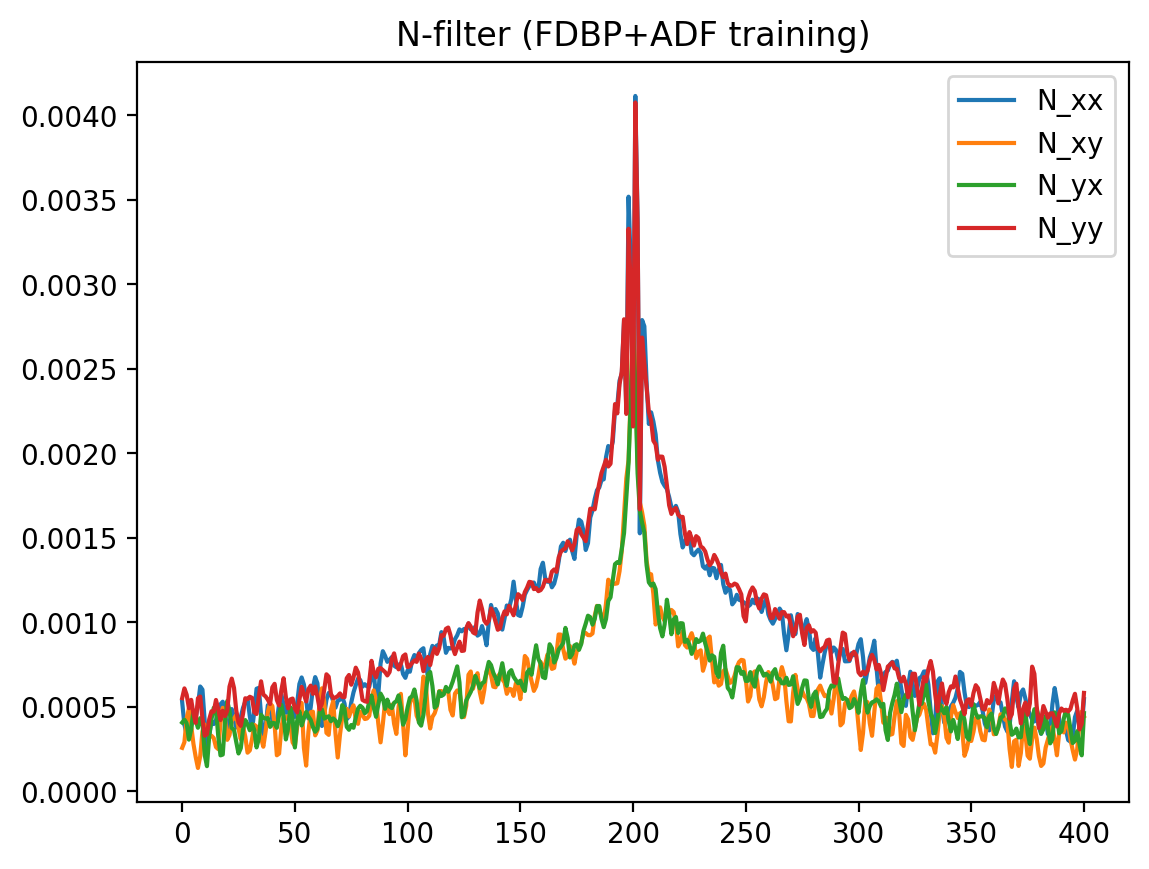

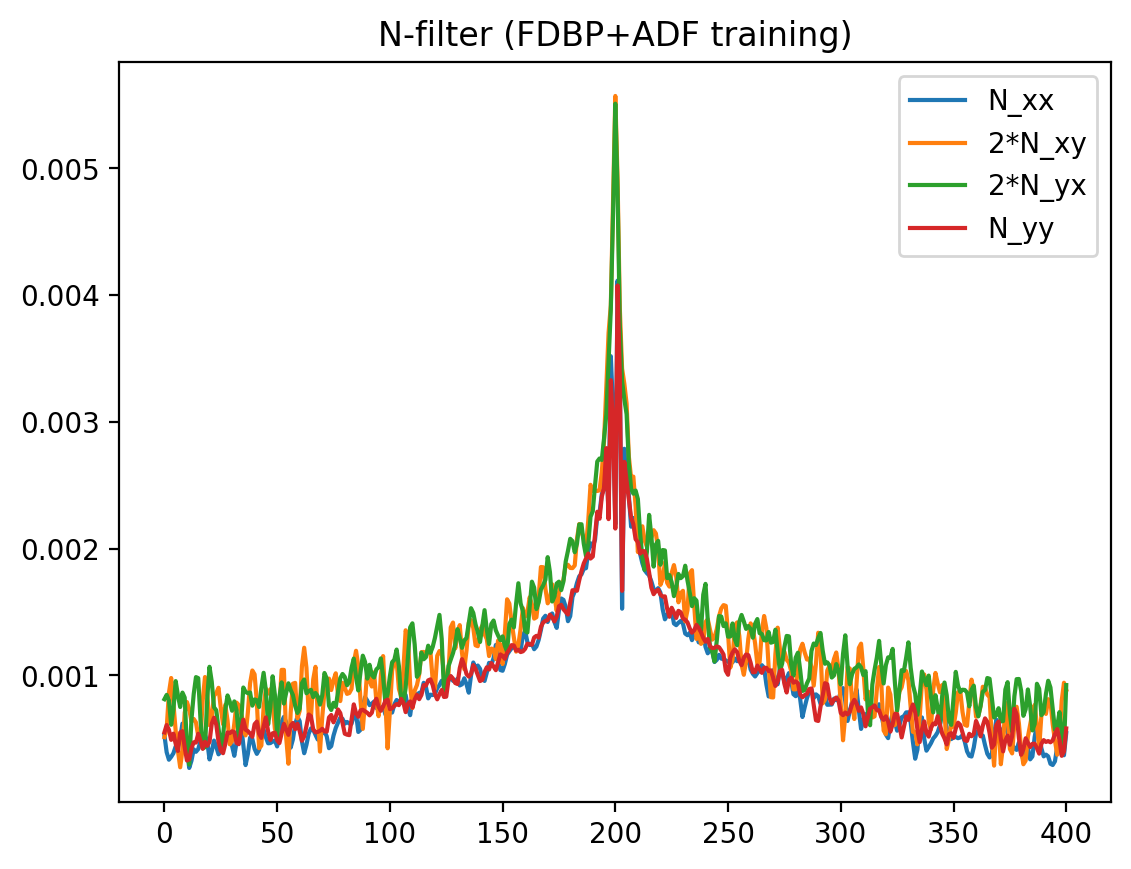

In [63]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[0,0].cpu().data, label='N_xx')
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[0,1].cpu().data, label='N_xy')
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[1,0].cpu().data, label='N_yx')
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[1,1].cpu().data, label='N_yy')
plt.legend()
plt.title('N-filter (FDBP+ADF training)')

plt.figure(dpi=200)
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[0,0].cpu().data, label='N_xx')
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[0,1].cpu().data*2, label='2*N_xy')
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[1,0].cpu().data*2, label='2*N_yx')
plt.plot(net.task_mlp(torch.ones(1)).reshape(2,2,401)[1,1].cpu().data, label='N_yy')
plt.legend()
plt.title('N-filter (FDBP+ADF training)')




# dic = torch.load('_models/metadsp/fdbp/61.pth')
# dic['model info']['DBP_info']['share'] = True
# model = DSP(**dic['model info'])
# model.load_state_dict(dic['model'])
# model = model.to(device)

# import matplotlib.pyplot as plt
# plt.figure(dpi=200)
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[0,0].cpu().data, label='N_xx')
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[0,1].cpu().data, label='N_xy')
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[1,0].cpu().data, label='N_yx')
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[1,1].cpu().data, label='N_yy')
# plt.legend()